# Importing Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from pandas import read_csv
import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import timedelta,date
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import time

In [2]:
df = pd.read_csv('CNQL6FZ01_5-16.csv')

In [3]:
df.t_stamp = pd.to_datetime(df.t_stamp)
df = df.set_index('t_stamp')
df.index.names = ['t_stamp']
df.index = pd.to_datetime(df.index)
df.tail()

,cnql6fz01_ndx,ReturnAir_Temp,OffProduct_LL_Temp,OnProduct_ML_Temp,OnProduct_UL_Temp,CoilA_AirOff_RTD_Error,CoilA_AirOff_Temp,CoilA_AirOn_RTD_Error,CoilA_AirOn_Temp,CoilA_Defrost,...,Alm_Belt_Takeup_Up,Alm_Estop_OutFeed,Alm_ProdHeight_Intern,BeltRunning,CIP_Enabled,CIP_Running,DrumDrive_Status,DrumDrives_Running,EStopOK,CIP_Status
t_stamp,,,,,,,,,,,,,,,,,,,,,
2023-05-16 10:28:12.903,51500,-15.130390,-25.248268,-22.980511,-26.382217,0.0,-19.0,0.0,-7.0,0.0,...,0.0,0.0,0.0,1.0,1,0,2.0,1,1.0,1.0
2023-05-16 10:29:12.907,51501,-15.350594,-25.211704,-23.090294,-26.382217,0.0,-19.0,0.0,-7.0,0.0,...,0.0,0.0,0.0,1.0,1,0,2.0,1,1.0,1.0
2023-05-16 10:30:12.907,51502,-15.754280,-25.211704,-23.090294,-26.455345,0.0,-19.0,0.0,-7.0,0.0,...,0.0,0.0,0.0,1.0,1,0,2.0,1,1.0,1.0
2023-05-16 10:31:12.907,51503,-16.194656,-25.467743,-23.492565,-26.674824,0.0,-20.0,0.0,-8.0,0.0,...,0.0,0.0,0.0,1.0,1,0,2.0,1,1.0,1.0
2023-05-16 10:32:12.907,51504,-16.891884,-25.833542,-24.150970,-27.150314,0.0,-21.0,0.0,-10.0,0.0,...,0.0,0.0,0.0,1.0,1,0,2.0,1,1.0,1.0


## Get weather data

In [4]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Hourly,Daily
#https://dev.meteostat.net/formats.html#meteorological-data-units
#https://dev.meteostat.net/api/stations/hourly.html#endpoint

# Set time period
start = min(df.index)
end = max(df.index)

# Create Point
location = Point(36.31874, -94.1208)

# Get daily data for 2018
weather_hr = Hourly(location, start, end)
weather_hr = weather_hr.fetch()

weather_d = Daily(location, start, end)
weather_d = weather_d.fetch()

#Date and time statements follow the ISO 8601 standard 
#(e.g. 2016-12-31 for December 31st 2016 and 23:59:58 for 23 hours, 59 minutes, and 58 seconds). 
#The time zone used by Meteostat is Coordinated Universal Time (UTC).
#Coordinated Universal Time is 5 hours ahead of Central Time
weather_hr.index = weather_hr.index - timedelta(hours=5)
#data[data.index == '2023-04-27 14:00:00']

In [5]:
weather_hr = weather_hr[['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco']]
weather_d = weather_d[['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]

In [6]:
weather_d.rename(columns={i:i+'_d' for i in weather_d.columns}, inplace=True)
weather_hr.rename(columns={i:i+'_hr' for i in weather_hr.columns}, inplace=True)

In [7]:
weather_hr.tail()

,temp_hr,dwpt_hr,rhum_hr,prcp_hr,wdir_hr,wspd_hr,pres_hr,coco_hr
time,,,,,,,,
2023-05-16 01:00:00,20.0,20.0,100.0,0.0,300.0,11.2,1017.5,3.0
2023-05-16 02:00:00,19.0,19.0,100.0,0.3,300.0,9.4,1017.0,7.0
2023-05-16 03:00:00,18.9,18.9,100.0,0.5,290.0,13.0,1016.2,5.0
2023-05-16 04:00:00,17.8,17.8,100.0,0.0,310.0,16.6,1016.2,5.0
2023-05-16 05:00:00,17.2,17.2,100.0,0.3,320.0,11.2,1016.2,5.0


# Data Preparation and Feature Engineering

In [8]:
### remove columns with std == 0 (not changing)
df = df.transpose()[(df.std()!=0)].transpose()

In [9]:
df = pd.merge_asof(df,weather_hr,left_on=df.index, right_on=weather_hr.index).set_index('key_0')
df = pd.merge_asof(df,weather_d,left_on=df.index, right_on=weather_d.index).set_index('key_0')
df.index.names = ['time']

In [10]:
df['No_Defrost'] = np.where((df['CoilA_Defrost'] == 0.0)&
                            (df['CoilB_Defrost'] == 0.0)&
                            (df['CoilC_Defrost'] == 0.0)&
                            (df['CoilD_Defrost'] == 0.0), 1, 0)

In [11]:
#temp at decision begin
def value_at_decision_begin(df,list_of_features):
    df['Time_From_Decision_Begin'] = 0
    dates = np.unique([i.strftime('%m/%d/%Y') for i in df.index.date])
    for l in list_of_features:
        df[f'{l}_Decision_Begin'] = 0
        for date in dates:
            for n in range(0,6):
                dt_0 = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
                dt_1 = dt_0+timedelta(hours=2.5)
                # since optimization take 9 - 10 mins to complete for every 2.5 hr, we subtract 0.1667 from
                df[f'{l}_Decision_Begin'][dt_0- timedelta(hours=0.1667):dt_1] = df[f'{l}'][df.index.get_loc(dt_0 - timedelta(hours=0.1667), method='nearest')]
    for date in dates:
        for n in range(0,6):
            dt_0 = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
            dt_1 = dt_0+timedelta(hours=2.5)
            df['Time_From_Decision_Begin'][dt_0 - timedelta(hours=0.1667):dt_1] = list(range(len(df['Time_From_Decision_Begin'][dt_0 - timedelta(hours=0.1667):dt_1])))
    
    return df
df = value_at_decision_begin(df,['ReturnAir_Temp'])

In [12]:
def count_continuous_ones(arr):
    l = [0]*len(arr)
    count = 0
    for i in range(1,len(arr)):
        if arr[i-1] == 1 and arr[i] == 1:
            count += 1
            l[i] = count
        else:
            count = 0
            
    return l

In [13]:
df.CoilA_Defrost = count_continuous_ones(list(df.CoilA_Defrost))
df.CoilB_Defrost = count_continuous_ones(list(df.CoilB_Defrost))
df.CoilC_Defrost = count_continuous_ones(list(df.CoilC_Defrost))
df.CoilD_Defrost = count_continuous_ones(list(df.CoilD_Defrost))
df.No_Defrost = count_continuous_ones(list(df.No_Defrost))

In [14]:
timeStart='07:30'
timeEnd='22:30'

df['date'] = df.index.date
df['dayOfWeek'] = df.index.dayofweek
df['hrOfDay'] = df.index.hour
df.dropna(inplace = True)

In [15]:
df = df[(df.dayOfWeek != 5) & 
        (df.dayOfWeek != 6) &
        (df.date != date(2023, 4, 13)) &
        (df.date != date(2023, 4, 17)) &
        (df.date != date(2023, 4, 22)) &
        (df.date != date(2023, 4, 29)) &
        (df.date != date(2023, 5, 6)) &
        (df.date != date(2023, 5, 7)) &

        (df.date != date(2023, 5, 13)) &
        (df.date != date(2023, 5, 14)) &

        (df.date != date(2023, 5, 19)) &
        (df.date != date(2023, 5, 20)) &
        (df.date != date(2023, 5, 21)) &

        (df.date != date(2023, 5, 27)) &
        (df.date != date(2023, 5, 28)) &
        (df.date != date(2023, 5, 29)) &
        (df.date != date(2023, 6, 3)) &
        (df.date != date(2023, 6, 4)) &
        (df.date != date(2023, 6, 5)) &

        (df.date != date(2023, 6, 10)) &
        (df.date != date(2023, 6, 11)) &   
        (df.date != date(2023, 6, 20)) &

     (df.date < date(2023, 7, 1))]

df = df.between_time(timeStart, timeEnd)

In [16]:
s = df.groupby(['date']).std().CoilA_Defrost < 6
print(s[s].index)
df = df[~df['date'].isin(s[s].index)]

Index([2023-05-16], dtype='object', name='date')


In [17]:
df = df[[
        #Target:
        'ReturnAir_Temp',
        
        #Decision:
        'CoilA_Defrost', 'CoilB_Defrost', 'CoilC_Defrost','CoilD_Defrost', 'No_Defrost',
        
        #Environment:
        'ReturnAir_Temp_Decision_Begin',
        'Time_From_Decision_Begin',
        'hrOfDay',
        'dayOfWeek', 
        
        #Weather:
        'pres_hr','rhum_hr','temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr', #'dwpt_hr', #'coco_hr',
        ]]

# Descriptive Analytics (Data Visualization)

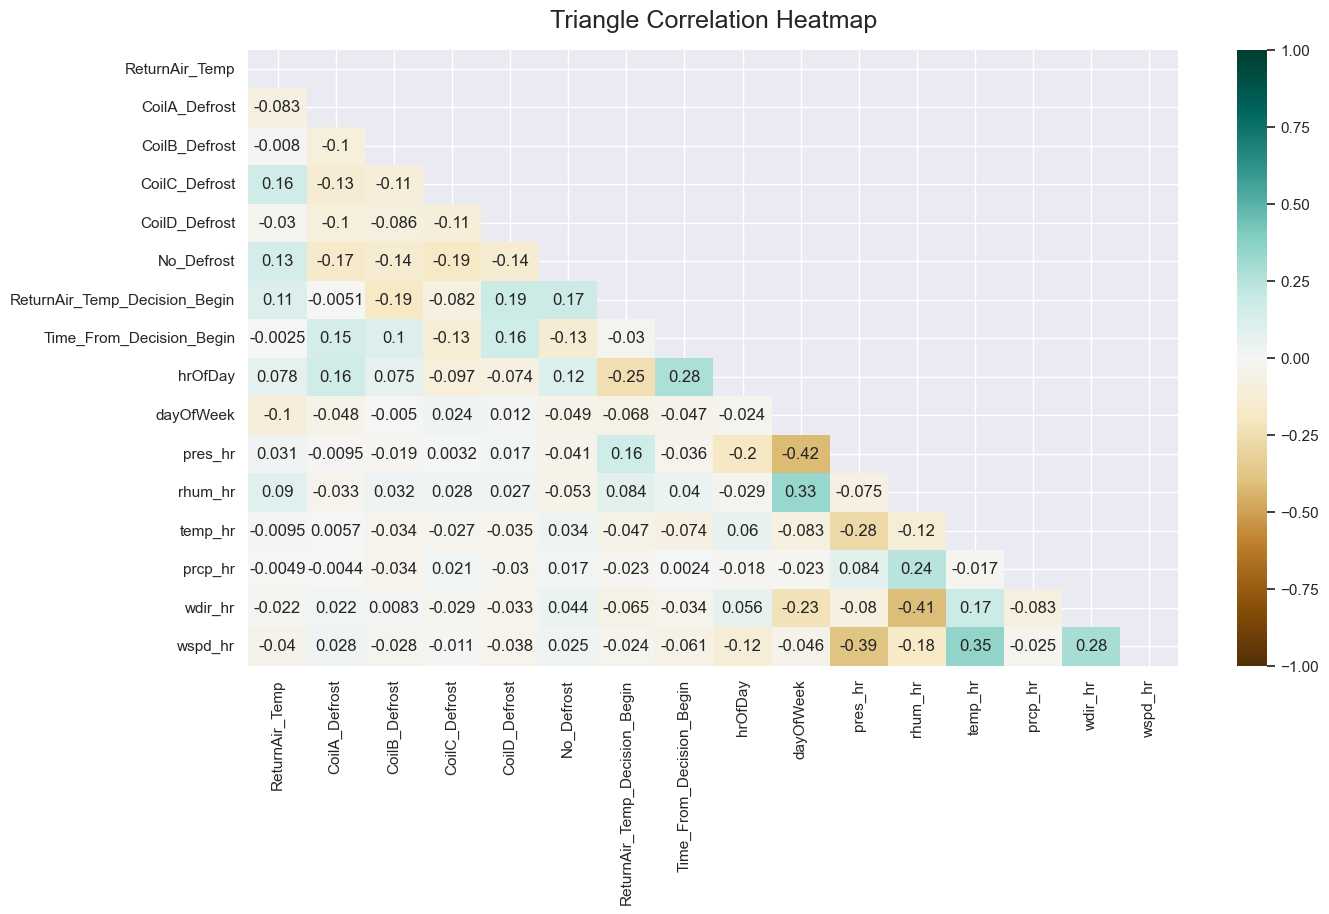

In [18]:
#Correlation Map for numeric variables:
# define the mask to set the values in the upper triangle to True
sns.set(rc = {'figure.figsize':(15,8)})

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

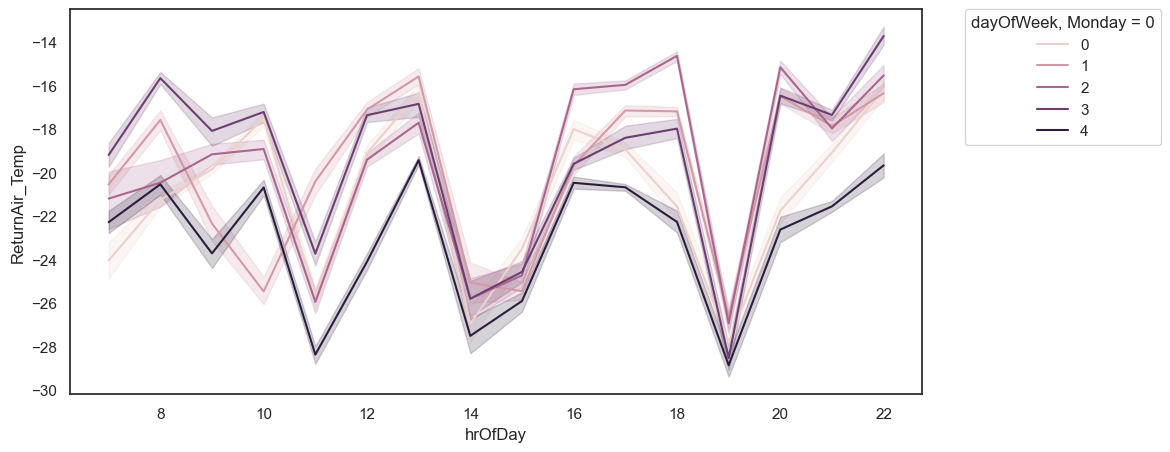

In [19]:
sns.set(rc={'figure.figsize':(11,5)})
sns.set_theme(style="white", palette=None)

sns.lineplot(data=df, x='hrOfDay', y="ReturnAir_Temp", hue="dayOfWeek")
plt.legend(bbox_to_anchor=(1.05, 1),  title = 'dayOfWeek, Monday = 0',loc=2, borderaxespad=0.)

In [20]:
df.columns

Index(['ReturnAir_Temp', 'CoilA_Defrost', 'CoilB_Defrost', 'CoilC_Defrost',
       'CoilD_Defrost', 'No_Defrost', 'ReturnAir_Temp_Decision_Begin',
       'Time_From_Decision_Begin', 'hrOfDay', 'dayOfWeek', 'pres_hr',
       'rhum_hr', 'temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr'],
      dtype='object')

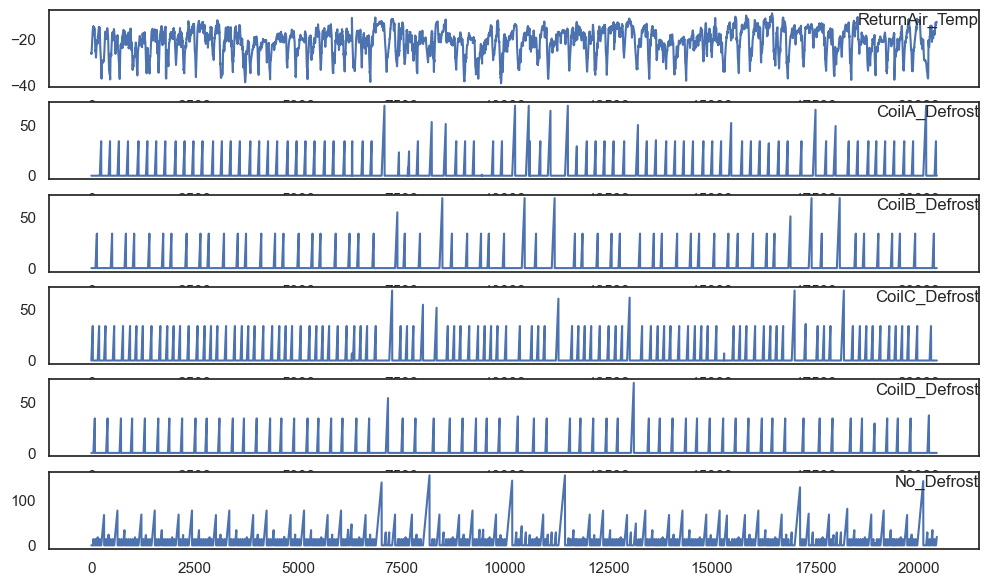

In [21]:
values = df.values
# specify columns to plot
#3,5
groups = [0,1,2,3,4,5]
i = 1
# plot each column
pyplot.figure(figsize=(12,7))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=
                 0.7, loc='right',size = 12)
    i += 1

pyplot.show()

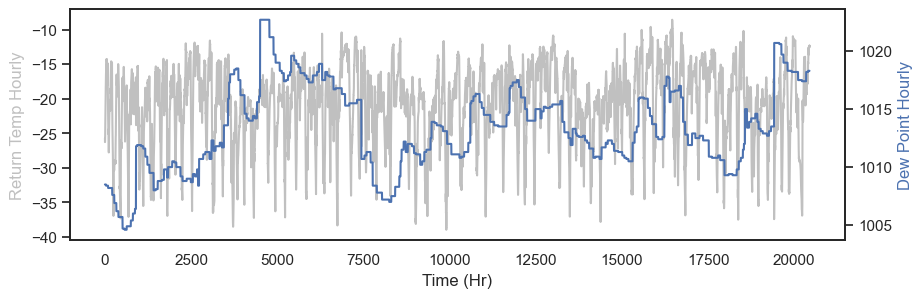

In [22]:
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("white")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  

y1 = list(df["ReturnAir_Temp"])
y2 = list(df["pres_hr"])

        
ax1.plot(y1, 'silver')
ax2.plot(y2, 'b-')

ax1.set_xlabel('Time (Hr)')
ax1.set_ylabel('Return Temp Hourly', color='silver')
ax2.set_ylabel('Dew Point Hourly', color='b')

plt.show()


# Predictive Analytics (XGBOOST)

In [23]:
df.dropna(inplace = True)

In [24]:
y = df['ReturnAir_Temp']
X = df.drop(columns=['ReturnAir_Temp'])

In [25]:
df.shape

(20441, 16)

In [26]:
#split the data based on the date
split_date="05-09-2023"
X_train=X.loc[X.index <=split_date].copy()
y_train=y.loc[y.index <=split_date].copy()
X_test=X.loc[X.index >split_date].copy()
y_test=y.loc[y.index >split_date].copy()

In [27]:
X_test_orig=X.loc[X.index >split_date].copy()

In [28]:
mm = MinMaxScaler()
X_train[X_train.columns] = mm.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = mm.transform(X_test[X_test.columns])

In [29]:
X_test.columns

Index(['CoilA_Defrost', 'CoilB_Defrost', 'CoilC_Defrost', 'CoilD_Defrost',
       'No_Defrost', 'ReturnAir_Temp_Decision_Begin',
       'Time_From_Decision_Begin', 'hrOfDay', 'dayOfWeek', 'pres_hr',
       'rhum_hr', 'temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr'],
      dtype='object')

### Hyperparam Tuning XGboost

In [30]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
#Import 'scope' from hyperopt in order to 
#obtain int values for certain hyperparameters.
from hyperopt.pyll.base import scope
hyperparameter_grid={'max_depth': scope.int(hp.quniform("max_depth", 1, 15, 1)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'eta': hp.uniform('eta', 0,1),            
        'seed': 0
    }

In [31]:
def objective(space):
    model = xgb.XGBRegressor(**space, early_stopping_rounds=100,  eval_metric="rmse")
    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_test, y_test)]
    #Fit the model. 
    model.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

In [32]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = hyperparameter_grid,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)

[16:28:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                          
26.103589128142158                                                              
[16:28:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an 

SCORE:                                                                          
34.13169735091443                                                               
[16:29:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                          
25.56607811410306                                                               
[16:29:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by la

In [33]:
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']
lowest_loss = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['loss']
print(best_model, lowest_loss)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100,
             enable_categorical=False, eta=0.2643024933335616,
             eval_metric='rmse', gamma=8.888108533166271, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.264302492, max_delta_step=0, max_depth=9,
             min_child_weight=2.0, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=10, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.9462000451470127, scale_pos_weight=1, seed=0,
             subsample=1, tree_method='exact', ...) 21.269130884195256


In [34]:
xgb_tuned=xgb.XGBRegressor(
                    max_dept=int(best_hyperparams['max_depth']),
                    #colsample_bytree=best_hyperparams['colsample_bytree'],
                    objective='reg:squarederror',
                    tree_method='hist',
                    eval_metrics='rmse',
                    eta=best_hyperparams['eta'],
                    gamma=best_hyperparams['gamma'],
                    min_child_weight=best_hyperparams['min_child_weight'],
                    early_stopping_rounds=500,
                    n_estimators=1000,
)
xgb_tuned.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=50)

[16:30:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_metrics", "max_dept" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:16.59803	validation_1-rmse:15.73152
[50]	validation_0-rmse:1.16721	validation_1-rmse:4.73273
[100]	validation_0-rmse:0.96868	validation_1-rmse:4.77505
[150]	validation_0-rmse:0.96868	validation_1-rmse:4.77505
[200]	validation_0-rmse:0.96868	validation_1-rmse:4.77505
[250]	validation_0-rmse:0.96868	validation_1-rmse:4.77505
[300]	validation_0-rmse:0.96868	validation_1-rmse:4.77505
[350]	validation_0-rmse:0.96868	validation_1-rmse:4.77505
[400]	validation_0-rmse:0.96868	validation_1-rmse:4.77505
[450]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=500,
             enable_categorical=False, eta=0.2643024933335616,
             eval_metrics='rmse', gamma=8.888108533166271, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.264302492, max_delta_step=0, max_dept=9,
             max_depth=6, min_child_weight=2.0, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='hist', ...)

### Feature Importance

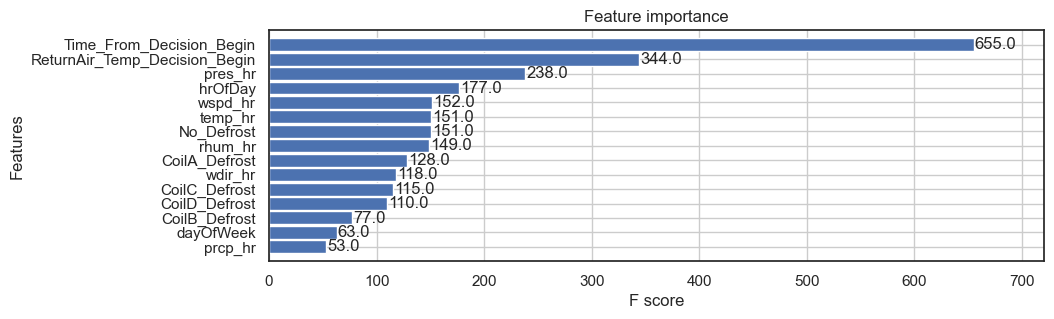

In [35]:
#clrs = ['red' if (x<288) and (x>100) else 'grey' for x in ]
_=plot_importance(xgb_tuned, height=0.9)

### Results and Visualization

In [36]:
xgb_preds = xgb_tuned.predict(X_test)
xgb_score = mean_squared_error(y_test, xgb_preds, squared=False)
print('RMSE_Best_Model:', xgb_score)

RMSE_Best_Model: 4.775049417304374


In [37]:
from sklearn.metrics import r2_score
r2_score(y_test, xgb_preds)

0.382675886570396

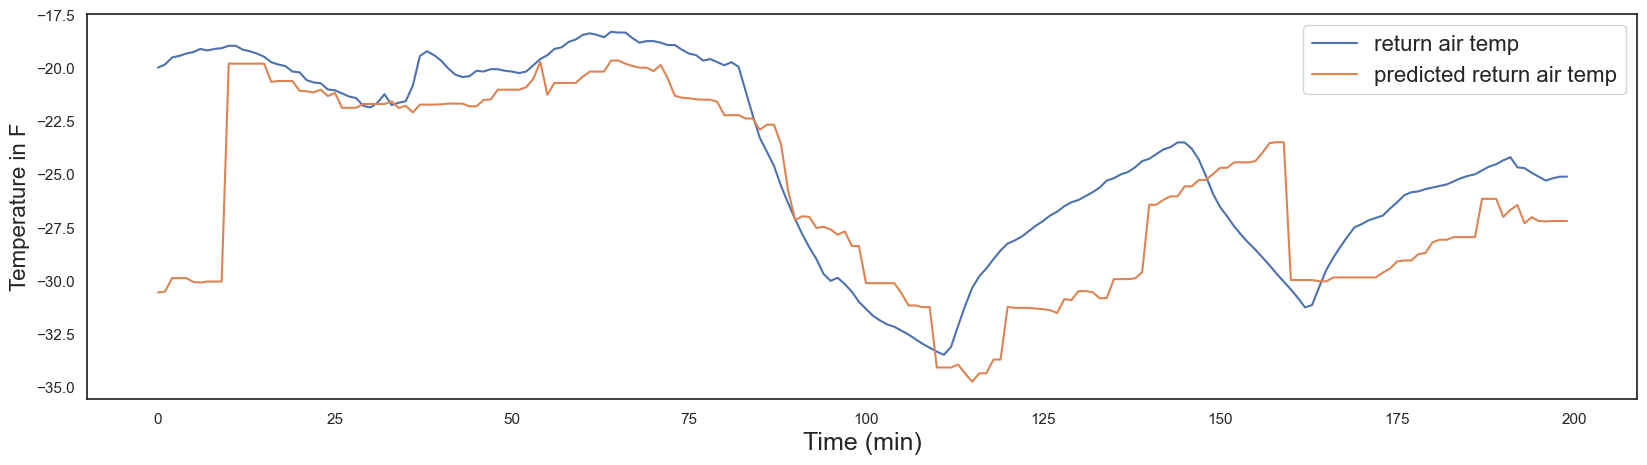

In [38]:
from random import randint
sns.set_style("white")
i = randint(0,len(y_test)-200)

pyplot.figure(figsize=(20,5))
pyplot.plot(list(y_test)[i:i+200], label='return air temp')
pyplot.plot(xgb_preds[i:i+200], label='predicted return air temp')
plt.xlabel('Time (min)', fontsize=18)
plt.ylabel('Temperature in F', fontsize=16)
plt.rc('legend', fontsize = 16)
pyplot.legend()
pyplot.show()

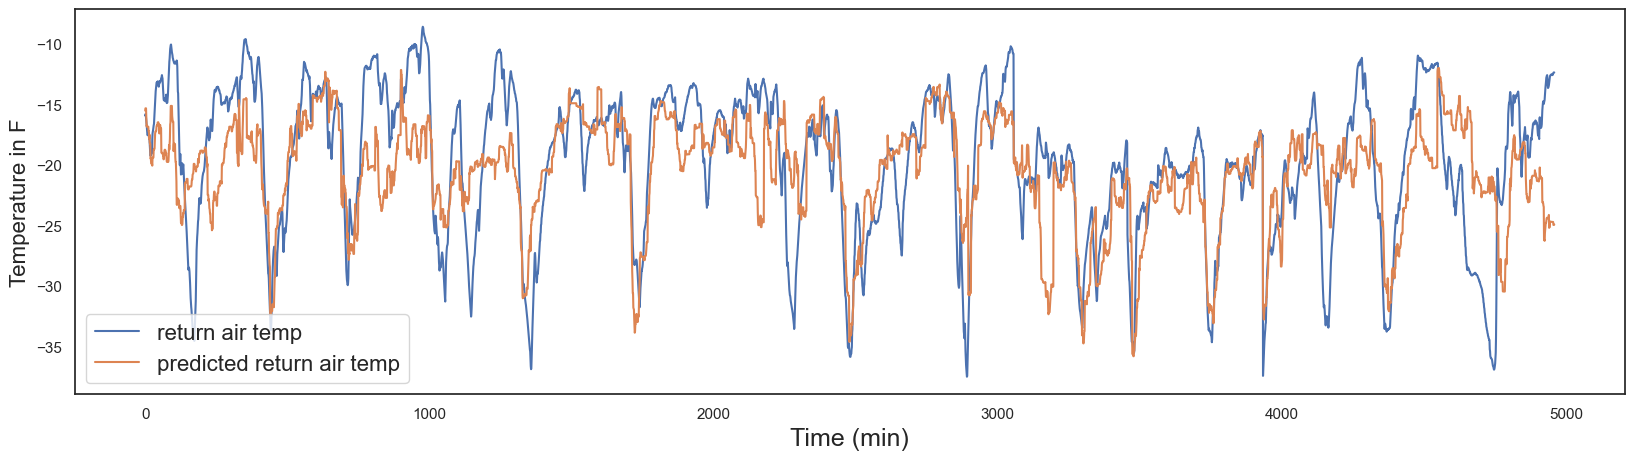

In [39]:
from random import randint
sns.set_style("white")

pyplot.figure(figsize=(20,5))
pyplot.plot(list(y_test)[0:-1], label='return air temp')
pyplot.plot(xgb_preds[0:-1], label='predicted return air temp')
plt.xlabel('Time (min)', fontsize=18)
plt.ylabel('Temperature in F', fontsize=16)
plt.rc('legend', fontsize = 16)
pyplot.legend()
pyplot.show()

# Prescriptive Analytics (Integer Programming)

In [40]:
def end_defrost_temp(i):
    # this function find the instruction and transformed to the way prediciton model wants to see. 
    n=int(np.argmax(i[0:5]))
    timer = i[5]
    mx = np.array([list(i)]*timer)
    mx[:, n] = [j for j in range(0,timer)]
    mx = np.delete(mx, 5, 1)
    mx = mm.transform(mx)
    xgb_preds = xgb_tuned.predict(mx)
    e = mean_squared_error([TARGET_TEMP]*len(xgb_preds), xgb_preds, squared=True)
    return xgb_preds[-1],xgb_preds,e

In [41]:
def arc_cost(s):
    costs = {}
    temps = {}
    for (i,j) in s:
        costs[(i,j)] = end_defrost_temp(i[:-1])[2]
        temps[(i,j)] = end_defrost_temp(i[:-1])[1]
    return costs,temps

In [42]:
decisions = [[1., 0., 0., 0., 0., 35],
             [0., 1., 0., 0., 0., 35],
             [0., 0., 1., 0., 0., 35],
             [0., 0., 0., 1., 0., 35],
             [0., 0., 0., 0., 1.,  5],
             [0., 0., 0., 0., 1., 10],
             [0., 0., 0., 0., 1., 20]]

In [43]:
dates = np.unique([i.strftime('%m/%d/%Y') for i in X_test.index.date])
TARGET_TEMP = -25
solutions = {}
dd = 0 #unique id for each generated node
for date in dates:
    dt_0 = pd.to_datetime(f"{date} 07:30:00.000")
    while dt_0 < pd.to_datetime(f"{date} 22:30:00.000"):
        ############## Create Network Flow Structure ###############
        start = time.time()
        print(f'Working on {dt_0}:')
        print('Creating network...')
        # This is the starting node for each batch of optimization network. The node starts with index 5 to include present tempreture.
        node_0 = X_test_orig.iloc[X_test_orig.index.get_loc(dt_0, method='nearest')][5:]      
        if dt_0 == pd.to_datetime(f"{date} 07:30:00.000"):
            #Assume Coil A defrost first everyday, which is (1,0,0,0,0....), dd is unique id for each generated node
            node_0 = [tuple(list(decisions[0])+list(node_0)+[dd])]
            dd = dd+1
        
        else:
            # If not first node of that day that means we need to use previous solution's last node, which will always end with the word sink.
            decision_prev = [i for (i,j) in Arcs if select[(i,j)].solution_value == 1 and j == 'sink']
            n=int(np.argmax(decision_prev[0][0:5]))
            node_0 = [tuple(list(decisions[n])+list(node_0)+[dd])]
            dd = dd+1
        # The following code is to generate time interval, right now it's hard code to look ahead 2.5 hours, which means we need 5 x 30mins intervals
        for t in range(1,6):
            globals()[f'dt_{t}'] = globals()[f'dt_{t-1}'] + timedelta(hours=0.5)
            globals()[f'node_{t}'] = X_test_orig.iloc[X_test_orig.index.get_loc(globals()[f'dt_{t}'], method='nearest')][6:]

        # This part connects the nodes in a dictionary form: The key is the origin node and the values in the dict are what the origin connects to. 
        node_1_dict = {}
        for n in node_0:
            node_1_dict[n] = [tuple(list(i)+[end_defrost_temp(n[:-1])[0]]+list(node_1)+[dd]) for i in decisions]
            dd = dd+1
        for p in range(2,6):
            globals()[f'node_{p}_dict'] = {}
            for q in globals()[f'node_{p-1}_dict'].keys():
                for n in globals()[f'node_{p-1}_dict'][q]:
                    globals()[f'node_{p}_dict'][n] = [tuple(list(i)+[end_defrost_temp(n[:-1])[0]]+list(globals()[f'node_{p}']) + [dd]) for i in decisions]
                    dd = dd+1
        
        # Unpacking dict into list of Arcs. 
        s0 = [(i,j) for i in node_1_dict.keys() for j in node_1_dict[i]]
        s1 = [(i,j) for i in node_2_dict.keys() for j in node_2_dict[i]]
        s2 = [(i,j) for i in node_3_dict.keys() for j in node_3_dict[i]]
        s3 = [(i,j) for i in node_4_dict.keys() for j in node_4_dict[i]]
        s4 = [(i,j) for i in node_5_dict.keys() for j in node_5_dict[i]]
        s5 = [(j,'sink') for (i,j) in s4]
    
        Arcs = set(s0 + s1 + s2 + s3 + s4 + s5)
        
        print('Almost there..')
        Arcs_cost, Arcs_temp = arc_cost(Arcs)
        
        end = time.time()
        print(f'Boom! Number of arcs generated is {len(Arcs_cost)}, total time spent creating arcs is {round(end-start)} s')
        
        ############## Define Node Supply ###############
        start = time.time()
        print('Setting network flow node supplies')
        Supply = {}
        for (i,j) in Arcs:
            #if i!=j:
                Supply[i] = 0
                Supply[j] = 0

        Supply[node_0[0]] = -1
        Supply['sink'] = 1

        from docplex.mp.model import Model
        mdl = Model()
        mdl.clear_constraints()
        mdl.remove_objective()
        print('Defining variables and objective')
        #Define Variables
        #select = mdl.continuous_var_dict(Arcs, lb=0, name='select')
        select = mdl.binary_var_dict(Arcs, lb=0, name='select')

        # objective
        mdl.minimize(mdl.sum(Arcs_cost[i]*select[i] for i in Arcs))
    
        ############## Add Flow Conservation Constraints ###############
        print('Adding flow conservation constraints..')
        con ={}
        for j in Supply.keys():
            inflow = mdl.sum(select[i,j] for i in Supply.keys() if (i,j) in Arcs)
            outflow = mdl.sum(select[j,i] for i in Supply.keys() if (j,i) in Arcs)
            con[j] = mdl.add_constraint(inflow - outflow == Supply[j])

        coil_defrost = {}
        coil_defrost_time = {}
        end = time.time()
        print(f'Total time adding flow objective and constraints is {round(end - start)} s')
        
        ############## Add Node Specific Constraints ###############
        print('Adding node contraints...')
        start = time.time()
        # Adding constraints: Each Coil defrost at least once in the current period or the last. 
        # If time is the beginning of the day, don't look for last period:
        if dt_0 == pd.to_datetime(f"{date} 07:30:00.000"):
            for w in range(0,4):
                coil_defrost[w]= mdl.add_constraint(mdl.sum(select[i,j]*i[w] for (i,j) in Arcs) == 1)
            mdl.add_constraint(mdl.sum(select[i,j]*i[5] for (i,j) in Arcs) == 150)
        else:
            previous_time = dt_0 - timedelta(hours=2.5)
            previous_time_sol = [i[:6] for (i,j) in list(solutions[previous_time].keys())]
            previous_time_sol = np.array([list(i) for i in previous_time_sol]).sum(axis = 0)
            previous_time_sol = [int(i) for i in previous_time_sol]
            for w in range(0,4):
                coil_defrost[w]= mdl.add_constraint(mdl.sum(select[i,j]*i[w] for (i,j) in Arcs) + previous_time_sol[w] >= 1)
                #coil_defrost[w]= mdl.add_constraint(mdl.sum(select[i,j]*i[w] for (i,j) in Arcs) + previous_time_sol[w] <= 2)
            mdl.add_constraint(mdl.sum(select[i,j]*i[5] for (i,j) in Arcs) + previous_time_sol[5] == 300)
        end = time.time()
        ############## Solve ###############
        print(f'Total time adding node constraints is {round(end - start,3)} s')
        start = time.time()
        print('Solving...')
        mdl.solve()
        end = time.time()
        print(f'Solved...total solving time is {round(end - start,3)} s')
        print('\n')
        solutions[dt_0] = {(i,j):Arcs_temp[(i,j)] for (i,j) in Arcs if select[(i,j)].solution_value == 1}
        #set initial time of the next optimization period
        dt_0 = dt_0 + timedelta(hours=2.5)


Working on 2023-05-09 07:30:00:
Creating network...
Almost there..
Boom! Number of arcs generated is 36414, total time spent creating arcs is 68 s
Setting network flow node supplies
Defining variables and objective
Adding flow conservation constraints..
Total time adding flow objective and constraints is 361 s
Adding node contraints...
Total time adding node constraints is 0.387 s
Solving...
Solved...total solving time is 6.144 s


Working on 2023-05-09 10:00:00:
Creating network...
Almost there..
Boom! Number of arcs generated is 36414, total time spent creating arcs is 70 s
Setting network flow node supplies
Defining variables and objective
Adding flow conservation constraints..
Total time adding flow objective and constraints is 356 s
Adding node contraints...
Total time adding node constraints is 0.373 s
Solving...
Solved...total solving time is 4.961 s


Working on 2023-05-09 12:30:00:
Creating network...
Almost there..
Boom! Number of arcs generated is 36414, total time spent cre

Solved...total solving time is 6.116 s


Working on 2023-05-12 10:00:00:
Creating network...
Almost there..
Boom! Number of arcs generated is 36414, total time spent creating arcs is 69 s
Setting network flow node supplies
Defining variables and objective
Adding flow conservation constraints..
Total time adding flow objective and constraints is 367 s
Adding node contraints...
Total time adding node constraints is 0.374 s
Solving...
Solved...total solving time is 4.96 s


Working on 2023-05-12 12:30:00:
Creating network...
Almost there..
Boom! Number of arcs generated is 36414, total time spent creating arcs is 69 s
Setting network flow node supplies
Defining variables and objective
Adding flow conservation constraints..
Total time adding flow objective and constraints is 358 s
Adding node contraints...
Total time adding node constraints is 0.371 s
Solving...
Solved...total solving time is 5.841 s


Working on 2023-05-12 15:00:00:
Creating network...
Almost there..
Boom! Number of arcs 

In [44]:
mdl.print_solution()

objective: 102.039
  "select_(0.0, 0.0, 0.0, 0.0, 1.0, 5, -20.456463, 70.0, 21.0, 0.0, 1018.2, 100.0, 20.0, 0.0, 310.0, 5.4, 81261)_(0.0, 0.0, 0.0, 0.0, 1.0, 5, -18.425629, 100.0, 21.0, 0.0, 1018.2, 100.0, 20.0, 0.0, 310.0, 5.4, 81278)"=1
  "select_(0.0, 0.0, 0.0, 1.0, 0.0, 35, -21.778345, 167.0, 22.0, 0.0, 1018.3, 100.0, 20.0, 0.0, 290.0, 5.4, 82228)_sink"=1
  "select_(0.0, 0.0, 0.0, 0.0, 1.0, 5, -18.425629, 100.0, 21.0, 0.0, 1018.2, 100.0, 20.0, 0.0, 310.0, 5.4, 81278)_(0.0, 0.0, 1.0, 0.0, 0.0, 35, -20.816456, 130.0, 22.0, 0.0, 1018.3, 100.0, 20.0, 0.0, 290.0, 5.4, 81397)"=1
  "select_(0.0, 1.0, 0.0, 0.0, 0.0, 35, -18.65338134765625, 10.0, 20.0, 0.0, 1017.4, 96.0, 20.6, 0.3, 0.0, 0.0, 81258)_(0.0, 1.0, 0.0, 0.0, 0.0, 35, -22.162165, 40.0, 20.0, 0.0, 1017.4, 96.0, 20.6, 0.3, 0.0, 0.0, 81259)"=1
  "select_(0.0, 0.0, 1.0, 0.0, 0.0, 35, -20.816456, 130.0, 22.0, 0.0, 1018.3, 100.0, 20.0, 0.0, 290.0, 5.4, 81397)_(0.0, 0.0, 0.0, 1.0, 0.0, 35, -21.778345, 167.0, 22.0, 0.0, 1018.3, 100.0, 20.

In [45]:
mdl.get_solve_details()

docplex.mp.SolveDetails(time=6.29169,status='integer optimal solution')

## Extract Solution for Visualization

In [46]:
l = []
dates = np.unique([i.strftime('%m/%d/%Y') for i in X_test.index.date])
#dates = ['2023-05-01']
for date in dates:
    for n in range(0,6):
        time = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
        
        start_id = min([i[-1] for (i,j) in list(solutions[time].keys())])
        start = [(i,j) for (i,j) in list(solutions[time].keys()) if i[-1] == start_id][0]
        
        l = l + list(solutions[time][start])
        i = start

        while i[1] != 'sink':
            for j in solutions[time].keys():
                if i != j:
                    if i[1] == j[0]:
                        l = l + list(solutions[time][j])
                        i = j
                        break

In [47]:
sd_0 = np.std(list(xgb_preds)[0:len(l)])
print(f'Predicted Temp Existing Defrost Sequence Standard Deviation: {sd_0:.2f}')

sd_2 = np.std(list(y_test)[0:len(l)])
print(f'Temp Actual Standard Deviation: {sd_2:.2f}')

sd_1 = np.std(l)
print(f'Predicted Temp Optimized Defrost Sequence Standard Deviation: {sd_1:.2f}')

percent_reduction = round((sd_0 - sd_1)*100/sd_0,2)
print(f'Standard Deviation Reduction After Optimization: {percent_reduction}%')

Predicted Temp Existing Defrost Sequence Standard Deviation: 4.38
Temp Actual Standard Deviation: 5.95
Predicted Temp Optimized Defrost Sequence Standard Deviation: 3.53
Standard Deviation Reduction After Optimization: 19.3%


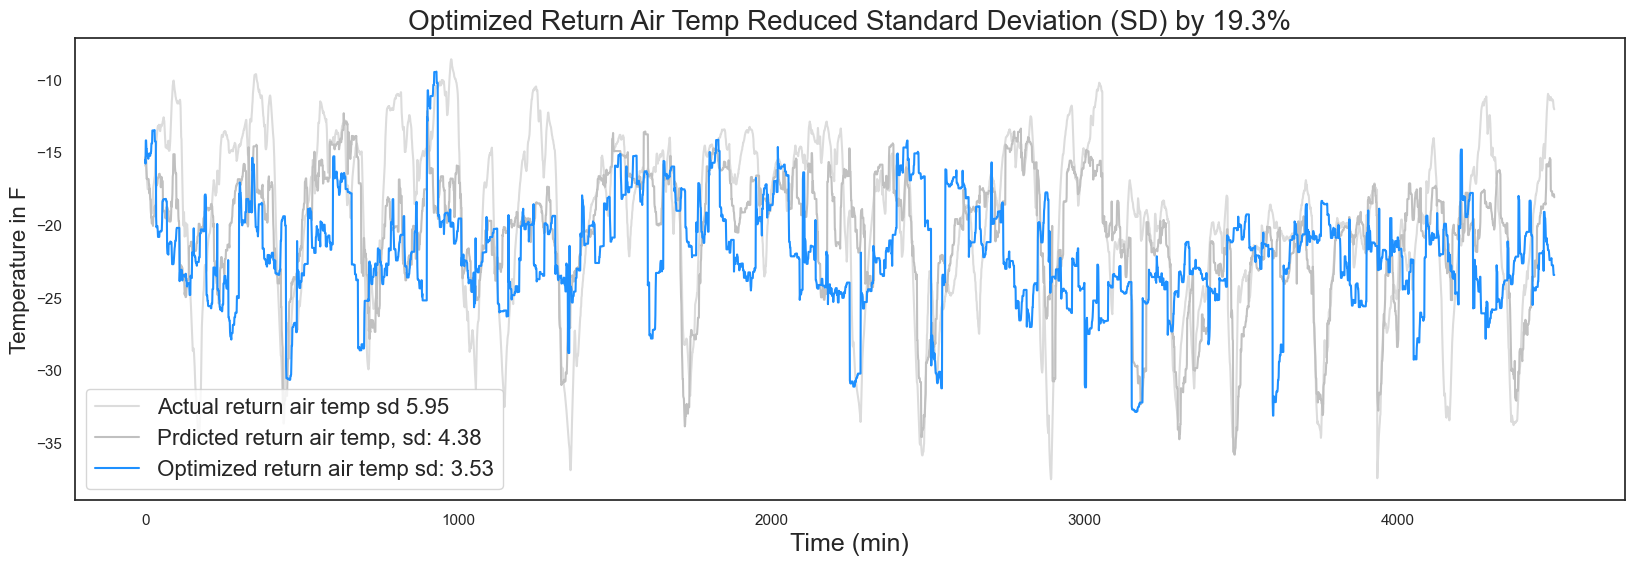

In [48]:
from random import randint
sns.set_style("white")

pyplot.figure(figsize=(20,6))
pyplot.plot(list(y_test)[0:len(l)], color='gainsboro', label=f'Actual return air temp sd {sd_2:.2f}')
pyplot.plot(list(xgb_preds)[0:len(l)],color='silver',  label=f'Prdicted return air temp, sd: {sd_0:.2f}')


pyplot.plot(l,color='dodgerblue', label=f'Optimized return air temp sd: {sd_1:.2f}')
plt.xlabel('Time (min)', fontsize=18)
plt.ylabel('Temperature in F', fontsize=16)
plt.title(f'Optimized Return Air Temp Reduced Standard Deviation (SD) by {percent_reduction}%',fontsize = 20)
plt.rc('legend', fontsize = 16)
pyplot.legend()
pyplot.show()

## Get Decisions

In [49]:
d = []
dates = np.unique([i.strftime('%m/%d/%Y') for i in X_test.index.date])
#dates = ['2023-05-01']
for date in dates:
    for n in range(0,6):
        time = pd.to_datetime(f"{date} 07:30:00.000") + timedelta(hours=n*2.5)
        
        d = d + sorted([i[:6] for (i,j) in list(solutions[time].keys())], key=lambda x: x[-1])
        

## Convert Decisions Into Time Series

In [50]:
from itertools import repeat

def convert_to_timeSequence(instruction_list,n):
    coil_instr = []
    for i in instruction_list:
        if np.argmax(i[:5]) == n:
            if np.argmax(i) != 4:
                coil_instr = coil_instr + list(repeat(1, 35))
            else:
                coil_instr = coil_instr + list(repeat(1, i[5]))
        elif np.argmax(i) == 4:
            coil_instr = coil_instr + list(repeat(0, i[5])) 
        else:
            coil_instr = coil_instr + list(repeat(0, 35))
        
    return coil_instr

In [51]:
CoilA_instructions = convert_to_timeSequence(d,0)
CoilB_instructions = convert_to_timeSequence(d,1)
CoilC_instructions = convert_to_timeSequence(d,2)
CoilD_instructions = convert_to_timeSequence(d,3)
NoDefrost_instructions = convert_to_timeSequence(d,4)

In [52]:
CoilA_instructions = count_continuous_ones(CoilA_instructions)
CoilB_instructions = count_continuous_ones(CoilB_instructions)
CoilC_instructions = count_continuous_ones(CoilC_instructions)
CoilD_instructions = count_continuous_ones(CoilD_instructions)
NoDefrost_instructions = count_continuous_ones(NoDefrost_instructions)

In [53]:
X_test_orig.columns

Index(['CoilA_Defrost', 'CoilB_Defrost', 'CoilC_Defrost', 'CoilD_Defrost',
       'No_Defrost', 'ReturnAir_Temp_Decision_Begin',
       'Time_From_Decision_Begin', 'hrOfDay', 'dayOfWeek', 'pres_hr',
       'rhum_hr', 'temp_hr', 'prcp_hr', 'wdir_hr', 'wspd_hr'],
      dtype='object')

In [54]:
split_date="05-09-2023"
X_test_orig=df.loc[df.index > split_date].copy()
ReturnAir_Temp = list(X_test_orig['ReturnAir_Temp'])
CoilA_Defrost = list(X_test_orig['CoilA_Defrost'])
CoilB_Defrost = list(X_test_orig['CoilB_Defrost'])
CoilC_Defrost = list(X_test_orig['CoilC_Defrost'])
CoilD_Defrost = list(X_test_orig['CoilD_Defrost'])
No_Defrost = list(X_test_orig['No_Defrost'])

In [55]:
df_instructions = pd.DataFrame(list(zip(ReturnAir_Temp,l,CoilA_instructions, CoilB_instructions,CoilC_instructions,CoilD_instructions,NoDefrost_instructions,
                                        CoilA_Defrost,CoilB_Defrost,CoilC_Defrost,CoilD_Defrost,No_Defrost)),
                                columns =['ReturnAir_Temp','Optimized_ReturnAir_Temp','CoilA_instructions', 'CoilB_instructions','CoilC_instructions','CoilD_instructions','NoDefrost_instructions',
                                         'CoilA_Defrost','CoilB_Defrost','CoilC_Defrost','CoilD_Defrost','No_Defrost'])

## Compare Optimized Decisions with Actual Decisions

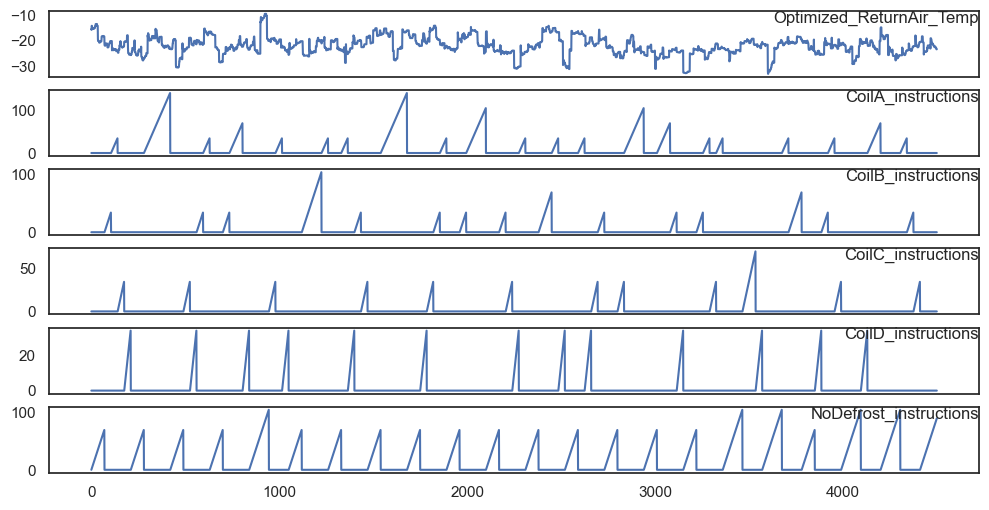

In [56]:
values = df_instructions.values
# specify columns to plot
#3,5
groups = [1,2,3,4,5,6]
i = 1
# plot each column
pyplot.figure(figsize=(12,6))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df_instructions.columns[group], y=0.7, loc='right',size = 12)
    i += 1

pyplot.show()

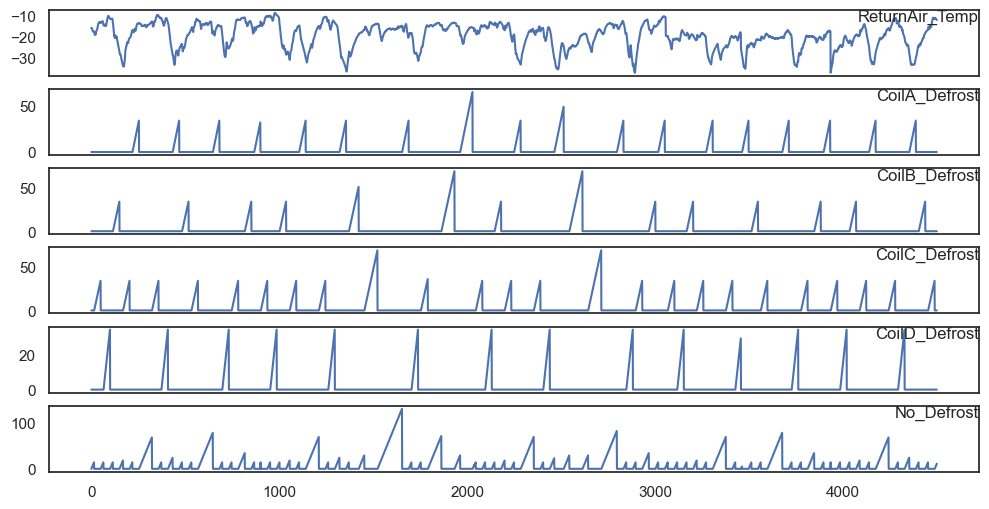

In [57]:
values = df_instructions.values
# specify columns to plot
#3,5
groups = [0,7,8,9,10,11]
i = 1
# plot each column
pyplot.figure(figsize=(12,6))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df_instructions.columns[group], y=0.7, loc='right',size = 12)
    i += 1

pyplot.show()